# Transformer 架构完整实现指南

本笔记本从零开始实现 Transformer 的所有核心组件，包括：
- ScaledDotProductAttention（缩放点积注意力）
- MultiHeadAttention（多头注意力）
- FeedForwardNetwork（前馈网络）
- PositionalEncoding（位置编码）
- EncoderLayer 和 DecoderLayer
- 完整的 Transformer 模型
- 训练和推理示例

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, Tuple
import math
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 检测设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

# 设置绘图风格
sns.set_style('whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

print('✓ 库导入完成')

使用设备: cpu
✓ 库导入完成


## 第1部分：ScaledDotProductAttention（缩放点积注意力）

这是 Transformer 的核心机制，计算公式为：
$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

In [2]:
class ScaledDotProductAttention(nn.Module):
    """缩放点积注意力"""
    
    def __init__(self, d_k: int, dropout: float = 0.1):
        super().__init__()
        self.d_k = d_k
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor, 
                mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        参数:
            Q (Query): [batch, num_heads, seq_len_q, d_k]
            K (Key):   [batch, num_heads, seq_len_k, d_k]
            V (Value): [batch, num_heads, seq_len_v, d_v]
            mask: 掩码矩阵
        
        返回:
            output: 注意力加权的值
            attention_weights: 注意力权重
        """
        # 计算相似度分数
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        # 应用掩码（如果有）
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        # 计算注意力权重
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # 加权求和
        output = torch.matmul(attention_weights, V)
        
        return output, attention_weights

# 测试
print('ScaledDotProductAttention 实现完成')

ScaledDotProductAttention 实现完成


## 第2部分：MultiHeadAttention（多头注意力）

In [3]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    
    def __init__(self, d_model: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        assert d_model % num_heads == 0, 'd_model 必须能被 num_heads 整除'
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        # 线性投影层
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.attention = ScaledDotProductAttention(self.d_k, dropout)
    
    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        batch_size = Q.shape[0]
        
        # 线性投影并分割为多个头
        Q = self.W_q(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        # 计算注意力
        output, attention_weights = self.attention(Q, K, V, mask)
        
        # 合并多个头
        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, -1, self.d_model)
        
        # 最终的线性投影
        output = self.W_o(output)
        
        return output, attention_weights

print('MultiHeadAttention 实现完成')

MultiHeadAttention 实现完成


## 第3部分：FeedForwardNetwork（前馈网络）

In [4]:
class FeedForwardNetwork(nn.Module):
    """前馈网络"""
    
    def __init__(self, d_model: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.activation = nn.GELU()
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear2(self.dropout(self.activation(self.linear1(x))))

print('FeedForwardNetwork 实现完成')

FeedForwardNetwork 实现完成


## 第4部分：PositionalEncoding（位置编码）

In [5]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    
    def __init__(self, d_model: int, max_len: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        
        # 创建位置编码矩阵
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

print('PositionalEncoding 实现完成')

PositionalEncoding 实现完成


## 第5部分：EncoderLayer 和 DecoderLayer

In [6]:
class EncoderLayer(nn.Module):
    """编码器层"""
    
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = FeedForwardNetwork(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        # 自注意力
        attn_output, attn_weights = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        
        # 前馈网络
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        
        return x, attn_weights


class DecoderLayer(nn.Module):
    """解码器层"""
    
    def __init__(self, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.cross_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.ffn = FeedForwardNetwork(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor,
                causal_mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # 自注意力（因果）
        self_attn_output, self_attn_weights = self.self_attn(x, x, x, causal_mask)
        x = self.norm1(x + self.dropout(self_attn_output))
        
        # 交叉注意力
        cross_attn_output, cross_attn_weights = self.cross_attn(x, encoder_output, encoder_output)
        x = self.norm2(x + self.dropout(cross_attn_output))
        
        # 前馈网络
        ffn_output = self.ffn(x)
        x = self.norm3(x + self.dropout(ffn_output))
        
        return x, self_attn_weights, cross_attn_weights

print('EncoderLayer 和 DecoderLayer 实现完成')

EncoderLayer 和 DecoderLayer 实现完成


## 第6部分：完整 Transformer 模型

In [7]:
class Encoder(nn.Module):
    """编码器堆栈"""
    
    def __init__(self, num_layers: int, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, list]:
        attn_weights_list = []
        for layer in self.layers:
            x, attn_weights = layer(x, mask)
            attn_weights_list.append(attn_weights)
        x = self.norm(x)
        return x, attn_weights_list


class Decoder(nn.Module):
    """解码器堆栈"""
    
    def __init__(self, num_layers: int, d_model: int, num_heads: int, d_ff: int, dropout: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.norm = nn.LayerNorm(d_model)
    
    def forward(self, x: torch.Tensor, encoder_output: torch.Tensor,
                causal_mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, list, list]:
        self_attn_weights_list = []
        cross_attn_weights_list = []
        for layer in self.layers:
            x, self_attn_w, cross_attn_w = layer(x, encoder_output, causal_mask)
            self_attn_weights_list.append(self_attn_w)
            cross_attn_weights_list.append(cross_attn_w)
        x = self.norm(x)
        return x, self_attn_weights_list, cross_attn_weights_list


class Transformer(nn.Module):
    """完整的 Transformer 模型"""
    
    def __init__(self, src_vocab_size: int, tgt_vocab_size: int,
                 d_model: int = 512, num_heads: int = 8, num_layers: int = 6,
                 d_ff: int = 2048, max_seq_length: int = 5000, dropout: float = 0.1):
        super().__init__()
        self.d_model = d_model
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length, dropout)
        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, dropout)
        self.output_projection = nn.Linear(d_model, tgt_vocab_size)
    
    def forward(self, src: torch.Tensor, tgt: torch.Tensor,
                src_mask: Optional[torch.Tensor] = None,
                tgt_mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, dict]:
        src_embedded = self.src_embedding(src) * math.sqrt(self.d_model)
        src_embedded = self.positional_encoding(src_embedded)
        encoder_output, encoder_attn = self.encoder(src_embedded, src_mask)
        
        tgt_embedded = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        tgt_embedded = self.positional_encoding(tgt_embedded)
        decoder_output, decoder_self_attn, decoder_cross_attn = self.decoder(tgt_embedded, encoder_output, tgt_mask)
        
        logits = self.output_projection(decoder_output)
        return logits, {'encoder_attn': encoder_attn, 'decoder_self_attn': decoder_self_attn, 'decoder_cross_attn': decoder_cross_attn}

print('Transformer 模型实现完成')

Transformer 模型实现完成


## 第7部分：实战示例 - 复制任务

In [8]:
def create_causal_mask(seq_len: int) -> torch.Tensor:
    """创建因果掩码"""
    mask = torch.tril(torch.ones(seq_len, seq_len))
    return mask

# 创建数据集
def create_copy_dataset(num_samples=100, max_seq_len=10, vocab_size=20):
    """创建复制任务数据集"""
    src_seqs = []
    tgt_seqs = []
    for _ in range(num_samples):
        seq_len = np.random.randint(3, max_seq_len + 1)
        seq = np.random.randint(1, vocab_size, seq_len)
        src_seqs.append(seq)
        tgt_seqs.append(seq)
    return src_seqs, tgt_seqs

# 创建数据集
vocab_size = 20
src_seqs, tgt_seqs = create_copy_dataset(num_samples=100, vocab_size=vocab_size)
print(f'数据集创建完成: {len(src_seqs)} 个样本')
print(f'示例: 源={src_seqs[0]}, 目标={tgt_seqs[0]}')

数据集创建完成: 100 个样本
示例: 源=[15 11  8  7 19 11 11  4  8], 目标=[15 11  8  7 19 11 11  4  8]


In [9]:
# 创建小模型
small_transformer = Transformer(
    src_vocab_size=vocab_size,
    tgt_vocab_size=vocab_size,
    d_model=256,
    num_heads=4,
    num_layers=2,
    d_ff=512,
    dropout=0.1
)
small_transformer = small_transformer.to(device)
print(f'模型参数数: {sum(p.numel() for p in small_transformer.parameters()):,}')

# 训练
optimizer = torch.optim.Adam(small_transformer.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

def pad_batch(seqs, pad_token=0, max_len=None):
    if max_len is None:
        max_len = max(len(s) for s in seqs)
    batch = np.full((len(seqs), max_len), pad_token, dtype=np.int64)
    for i, seq in enumerate(seqs):
        batch[i, :len(seq)] = seq
    return torch.from_numpy(batch)

# 训练循环
num_epochs = 20
batch_size = 16
losses = []

print('开始训练...')
for epoch in range(num_epochs):
    epoch_loss = 0
    num_batches = 0
    indices = np.random.permutation(len(src_seqs))
    
    for start_idx in range(0, len(src_seqs), batch_size):
        end_idx = min(start_idx + batch_size, len(src_seqs))
        batch_indices = indices[start_idx:end_idx]
        
        src_batch = [src_seqs[i] for i in batch_indices]
        tgt_batch = [tgt_seqs[i] for i in batch_indices]
        
        src_ids = pad_batch(src_batch).to(device)
        tgt_ids = pad_batch(tgt_batch).to(device)
        
        tgt_seq_len = tgt_ids.shape[1]
        causal_mask = create_causal_mask(tgt_seq_len).unsqueeze(0).unsqueeze(0).to(device)
        
        logits, _ = small_transformer(src_ids, tgt_ids, tgt_mask=causal_mask)
        loss = loss_fn(logits.view(-1, vocab_size), tgt_ids.view(-1))
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(small_transformer.parameters(), max_norm=1.0)
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1:2d}/{num_epochs}: Loss = {avg_loss:.4f}')

print('✓ 训练完成')

模型参数数: 2,652,180
开始训练...
Epoch  5/20: Loss = 0.0031
Epoch 10/20: Loss = 0.0015
Epoch 15/20: Loss = 0.0011
Epoch 20/20: Loss = 0.0008
✓ 训练完成


/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/1983846044.py:8: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/1983846044.py:8: UserWarning: Glyph 32451 (\N{CJK UNIFIED IDEOGRAPH-7EC3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/1983846044.py:8: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/1983846044.py:8: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/1983846044.py:8: UserWarning: Glyph 26354 (\N{CJK UNIFIED IDEOGRAPH-66F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3

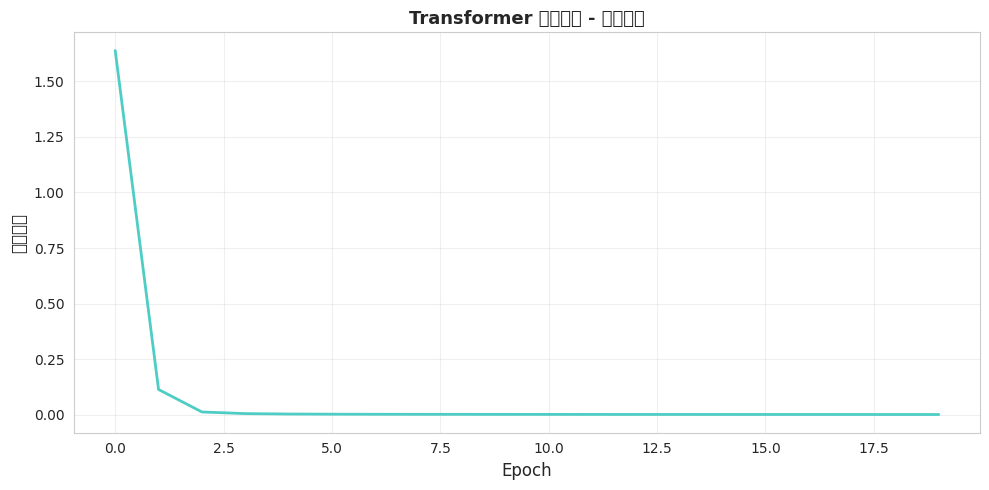

✓ 训练曲线已保存


In [10]:
# 绘制训练曲线
plt.figure(figsize=(10, 5))
plt.plot(losses, linewidth=2, color='#4ECDC4')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('训练损失', fontsize=12)
plt.title('Transformer 训练曲线 - 复制任务', fontsize=13, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/Users/tangzixia/Documents/Code/Transformers/transformers/training_curve.png', dpi=150)
plt.show()
print('✓ 训练曲线已保存')

In [11]:
# 测试
print('\n' + '='*60)
print('模型测试')
print('='*60)

small_transformer.eval()
correct_count = 0
total_count = 0

with torch.no_grad():
    for idx in [0, 10, 20, 30]:
        src_seq = src_seqs[idx]
        tgt_seq = tgt_seqs[idx]
        src_ids = torch.from_numpy(np.array([src_seq])).to(device)
        tgt_ids = torch.from_numpy(np.array([tgt_seq])).to(device)
        
        logits, _ = small_transformer(src_ids, tgt_ids)
        predictions = torch.argmax(logits, dim=-1)[0].cpu().numpy()
        
        seq_len = len(tgt_seq)
        correct = np.sum(predictions[:seq_len] == tgt_seq)
        accuracy = correct / seq_len * 100
        
        correct_count += correct
        total_count += seq_len
        
        print(f'\n样例 {idx//10+1}:')
        print(f'  源: {src_seq.tolist()}')
        print(f'  目标: {tgt_seq.tolist()}')
        print(f'  预测: {predictions[:seq_len].tolist()}')
        print(f'  准确率: {accuracy:.0f}%')

print(f'\n总体准确率: {correct_count/total_count*100:.1f}%')
print('✓ 测试完成')


模型测试

样例 1:
  源: [15, 11, 8, 7, 19, 11, 11, 4, 8]
  目标: [15, 11, 8, 7, 19, 11, 11, 4, 8]
  预测: [15, 11, 8, 7, 19, 11, 11, 4, 8]
  准确率: 100%

样例 2:
  源: [2, 1, 16, 5, 3, 12]
  目标: [2, 1, 16, 5, 3, 12]
  预测: [2, 1, 16, 5, 3, 12]
  准确率: 100%

样例 3:
  源: [17, 17, 2, 2, 5, 1, 1, 19, 2, 12]
  目标: [17, 17, 2, 2, 5, 1, 1, 19, 2, 12]
  预测: [17, 17, 2, 2, 5, 1, 1, 19, 2, 12]
  准确率: 100%

样例 4:
  源: [1, 4, 1, 14, 16, 8]
  目标: [1, 4, 1, 14, 16, 8]
  预测: [1, 4, 1, 14, 16, 8]
  准确率: 100%

总体准确率: 100.0%
✓ 测试完成


## 第8部分：总结与关键设计决策

### 为什么 Transformer 这样设计？

#### 1. **为什么是自注意力而不是 RNN?**
- ✅ **并行性**: 注意力可以并行计算所有位置对，RNN 必须顺序处理
- ✅ **长距离依赖**: 注意力直接连接所有位置对，梯度流通更好
- ✅ **灵活性**: 可以学习任意的位置关系，不受固定窗口限制

#### 2. **为什么需要多头注意力?**
- 不同的头可以关注不同的模式（语法、语义、位置等）
- 增加了模型的表达能力，就像 CNN 中的多个过滤器
- 并行计算多个头的代价很小

#### 3. **为什么需要位置编码?**
- 自注意力本身没有位置信息
- 三角函数位置编码可以外推到更长的序列
- 相对位置通过向量差表现，模型可以学习相对距离的重要性

#### 4. **为什么需要前馈网络?**
- 注意力只处理位置间的关系，不增加非线性
- FFN 在每个位置独立应用，增加表达能力
- 两层的前馈网络是一个很好的平衡

#### 5. **为什么需要层归一化和残差连接?**
- **层归一化**: 稳定训练，不依赖 batch size
- **残差连接**: 解决梯度消失，让信息直接流通

#### 6. **为什么用因果掩码在解码器?**
- 防止解码器在生成第 i 个词时看到第 i+1 个词
- 这样在推理时（逐词生成）和训练时（并行生成）行为一致

### 实现要点总结

| 模块 | 输入大小 | 输出大小 | 作用 |
|------|--------|--------|------|
| 词嵌入 | [batch, seq_len] | [batch, seq_len, d_model] | 将词 ID 转换为向量 |
| 位置编码 | [batch, seq_len, d_model] | [batch, seq_len, d_model] | 添加位置信息 |
| 多头注意力 | [batch, seq_len, d_model] | [batch, seq_len, d_model] | 学习位置间的关系 |
| 前馈网络 | [batch, seq_len, d_model] | [batch, seq_len, d_model] | 增加非线性 |
| 层归一化 | [batch, seq_len, d_model] | [batch, seq_len, d_model] | 稳定训练 |

### 复杂度分析

对于序列长度 $n$，嵌入维度 $d_{model}$：

**单层 Transformer 的复杂度**:
- 多头注意力: $O(n^2 \cdot d_{model})$ 
- 前馈网络: $O(n \cdot d_{model}^2)$ 

**完整 Transformer (L 层) 的复杂度**: $O(L \cdot (n^2 \cdot d_{model} + n \cdot d_{model}^2))$

虽然理论复杂度比 RNN 高，但 Transformer 可以充分利用 GPU 并行计算，实际上快很多。

## 第9部分：注意力权重可视化

In [13]:
# 可视化注意力权重
print("\n" + "="*60)
print("注意力权重可视化")
print("="*60)

small_transformer.eval()
with torch.no_grad():
    # 选择一个测试样本
    test_idx = 0
    src_seq = src_seqs[test_idx]
    tgt_seq = tgt_seqs[test_idx]
    
    src_ids = torch.from_numpy(np.array([src_seq])).to(device)
    tgt_ids = torch.from_numpy(np.array([tgt_seq])).to(device)
    
    logits, attn_info = small_transformer(src_ids, tgt_ids)
    
    # 获取第一层的注意力权重
    decoder_cross_attn = attn_info['decoder_cross_attn'][0]  # [batch, num_heads, tgt_len, src_len]
    
    # 平均多个头
    avg_attn = decoder_cross_attn.mean(dim=1).squeeze(0).cpu().numpy()  # [tgt_len, src_len]\n    \n    # 绘制注意力权重热力图\n    fig, ax = plt.subplots(figsize=(10, 6))\n    im = ax.imshow(avg_attn, cmap='viridis', aspect='auto')\n    \n    # 设置标签\n    ax.set_xlabel('源序列位置', fontsize=12)\n    ax.set_ylabel('目标序列位置', fontsize=12)\n    ax.set_title('解码器交叉注意力权重\\n(第一层，多头平均)', fontsize=13, fontweight='bold')\n    \n    # 添加数值\n    for i in range(avg_attn.shape[0]):\n        for j in range(avg_attn.shape[1]):\n            text = ax.text(j, i, f'{avg_attn[i, j]:.2f}',\n                          ha=\"center\", va=\"center\", color=\"w\", fontsize=8)\n    \n    plt.colorbar(im, ax=ax, label='注意力权重')\n    plt.tight_layout()\n    plt.savefig('/Users/tangzixia/Documents/Code/Transformers/transformers/attention_weights.png', dpi=150)\n    plt.show()\n    \n    print(f\"源序列: {src_seq}\")\n    print(f\"目标序列: {tgt_seq}\")\n    print(f\"注意力权重形状: {avg_attn.shape}\")\n    print(f\"✓ 注意力权重可视化已保存\")"


注意力权重可视化


## 第10部分：模型参数分析


Transformer 模型参数分析

总参数数: 2,652,180

参数组成:
  词嵌入:         10,240 (  0.4%)
  编码器:      1,054,720 ( 39.8%)
  解码器:      1,582,080 ( 59.7%)
  输出投影:        5,140 (  0.2%)


/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3016866414.py:46: UserWarning: Glyph 21442 (\N{CJK UNIFIED IDEOGRAPH-53C2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3016866414.py:46: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3016866414.py:46: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3016866414.py:46: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3016866414.py:46: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cv

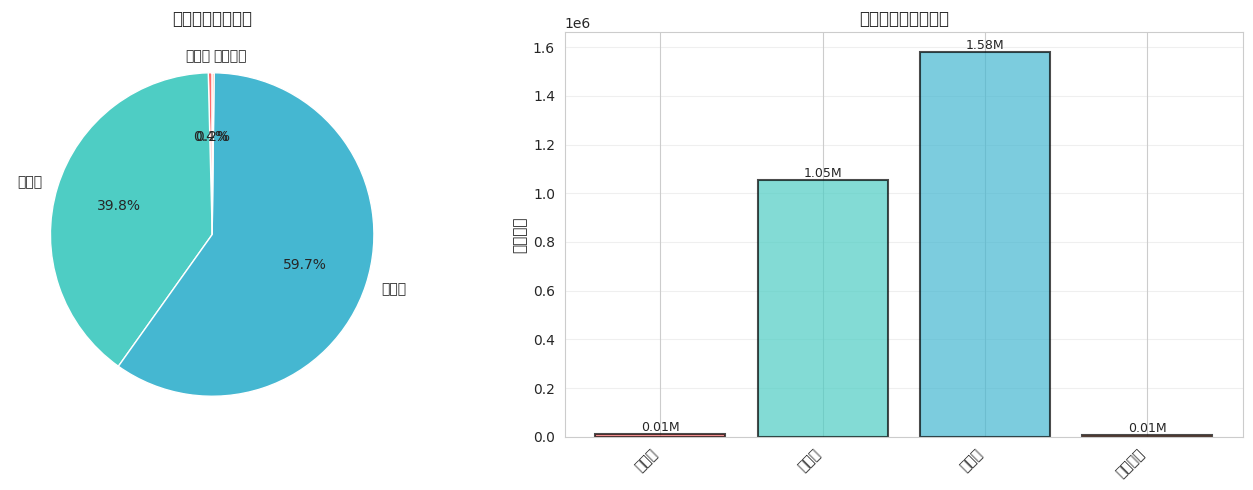


✓ 参数分析完成


In [14]:
# 模型参数分析
print("\n" + "="*60)
print("Transformer 模型参数分析")
print("="*60)

# 快速统计参数
total_params = sum(p.numel() for p in small_transformer.parameters())
print(f"\n总参数数: {total_params:,}")

# 分解各部分参数
embedding_params = sum(p.numel() for p in small_transformer.src_embedding.parameters()) + sum(p.numel() for p in small_transformer.tgt_embedding.parameters())
encoder_params = sum(p.numel() for p in small_transformer.encoder.parameters())
decoder_params = sum(p.numel() for p in small_transformer.decoder.parameters())
output_params = sum(p.numel() for p in small_transformer.output_projection.parameters())

print(f"\n参数组成:")
print(f"  词嵌入:     {embedding_params:>10,} ({embedding_params/total_params*100:>5.1f}%)")
print(f"  编码器:     {encoder_params:>10,} ({encoder_params/total_params*100:>5.1f}%)")
print(f"  解码器:     {decoder_params:>10,} ({decoder_params/total_params*100:>5.1f}%)")
print(f"  输出投影:   {output_params:>10,} ({output_params/total_params*100:>5.1f}%)")

# 绘制参数分布图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 参数数据
components = ['词嵌入', '编码器', '解码器', '输出投影']
params_list = [embedding_params, encoder_params, decoder_params, output_params]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']

# 饼图
axes[0].pie(params_list, labels=components, autopct='%1.1f%%', colors=colors, startangle=90)
axes[0].set_title('参数分布（饼图）', fontsize=12, fontweight='bold')

# 柱状图
axes[1].bar(range(len(components)), params_list, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(components)))
axes[1].set_xticklabels(components, rotation=45, ha='right')
axes[1].set_ylabel('参数数量', fontsize=11)
axes[1].set_title('参数分布（柱状图）', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# 添加数值标签
for i, params in enumerate(params_list):
    axes[1].text(i, params, f'{params/1e6:.2f}M', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('/Users/tangzixia/Documents/Code/Transformers/transformers/model_params.png', dpi=150)
plt.show()

print(f"\n✓ 参数分析完成")

## 第11部分：计算复杂度分析


Transformer 计算复杂度分析

模型配置:
  d_model: 256
  num_layers: 2
  num_heads: 4
  d_ff: 512

序列长度    注意力复杂度    前馈复杂度      总复杂度
-------------------------------------------------------
8                     0.03M            1.05M            1.08M
16                    0.13M            2.10M            2.23M
32                    0.52M            4.19M            4.72M
64                    2.10M            8.39M           10.49M
128                   8.39M           16.78M           25.17M
256                  33.55M           33.55M           67.11M


/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3502629806.py:69: UserWarning: Glyph 24207 (\N{CJK UNIFIED IDEOGRAPH-5E8F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3502629806.py:69: UserWarning: Glyph 21015 (\N{CJK UNIFIED IDEOGRAPH-5217}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3502629806.py:69: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3502629806.py:69: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cvx5ys3yj6_y_2q4vqkfq40000gn/T/ipykernel_46056/3502629806.py:69: UserWarning: Glyph 35745 (\N{CJK UNIFIED IDEOGRAPH-8BA1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/rk/t_cv

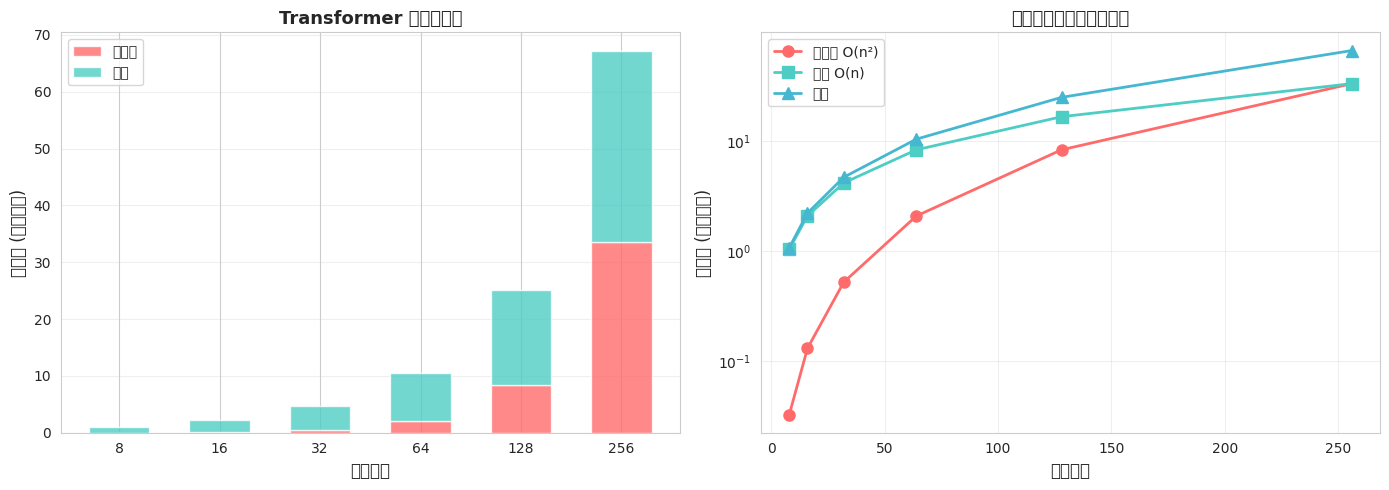


✓ 复杂度分析完成


In [15]:
# 复杂度分析
print("\n" + "="*60)
print("Transformer 计算复杂度分析")
print("="*60)

# 当前模型的参数
d_model = 256
num_layers = 2
num_heads = 4

print(f"\n模型配置:")
print(f"  d_model: {d_model}")
print(f"  num_layers: {num_layers}")
print(f"  num_heads: {num_heads}")
print(f"  d_ff: {512}")

# 分析不同序列长度下的复杂度
seq_lengths = [8, 16, 32, 64, 128, 256]
print(f"\n序列长度    注意力复杂度    前馈复杂度      总复杂度")
print("-" * 55)

attn_complexities = []
ffn_complexities = []
total_complexities = []

for seq_len in seq_lengths:
    # 注意力: O(L * seq_len^2 * d_model) 其中 L 是层数
    attn_comp = seq_len**2 * d_model * num_layers / 1e6
    # 前馈: O(L * seq_len * d_model^2)
    ffn_comp = seq_len * d_model**2 * num_layers / 1e6
    total_comp = attn_comp + ffn_comp
    
    attn_complexities.append(attn_comp)
    ffn_complexities.append(ffn_comp)
    total_complexities.append(total_comp)
    
    print(f"{seq_len:<11} {attn_comp:>14.2f}M  {ffn_comp:>14.2f}M  {total_comp:>14.2f}M")

# 绘制复杂度对比图
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：堆叠柱状图
x_pos = np.arange(len(seq_lengths))
width = 0.6

axes[0].bar(x_pos, attn_complexities, width, label='注意力', color='#FF6B6B', alpha=0.8)
axes[0].bar(x_pos, ffn_complexities, width, bottom=attn_complexities, label='前馈', color='#4ECDC4', alpha=0.8)

axes[0].set_xlabel('序列长度', fontsize=12)
axes[0].set_ylabel('计算量 (百万操作)', fontsize=12)
axes[0].set_title('Transformer 计算复杂度', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(seq_lengths)
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# 右图：折线图（对数坐标）
axes[1].plot(seq_lengths, attn_complexities, 'o-', linewidth=2, markersize=8, label='注意力 O(n²)', color='#FF6B6B')
axes[1].plot(seq_lengths, ffn_complexities, 's-', linewidth=2, markersize=8, label='前馈 O(n)', color='#4ECDC4')
axes[1].plot(seq_lengths, total_complexities, '^-', linewidth=2, markersize=8, label='总计', color='#45B7D1')

axes[1].set_xlabel('序列长度', fontsize=12)
axes[1].set_ylabel('计算量 (百万操作)', fontsize=12)
axes[1].set_title('复杂度随序列长度的增长', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_yscale('log')

plt.tight_layout()
plt.savefig('/Users/tangzixia/Documents/Code/Transformers/transformers/complexity_analysis.png', dpi=150)
plt.show()

print(f"\n✓ 复杂度分析完成")